# Logistic Regression

In our **Linear Regression** notebook, we looked at predicting continuous values (like projecting house prices, or estimating weight from height). That was all about fitting a line through data to *approximate numbers*.  

But what if our problem is **not about numbers**, but about **decisions**? For example:
- Is an email spam or not spam?  
- Does a patient test positive or negative?  
- Is a point in one group or another?  

That’s where **Logistic Regression** comes in. Instead of predicting continuous values, we’ll train a model that learns to **separate two classes** with a line (in 2D) or a plane (in higher dimensions).  

Let’s start by synthesizing a simple 2-feature dataset with two classes. We’ll visualize the points, and we’ll also plot an “ideal” separating line that divides them as best as possible. The goal of logistic regression will be to *learn* the equation of this line.  


(4000, 2)
(4000,)


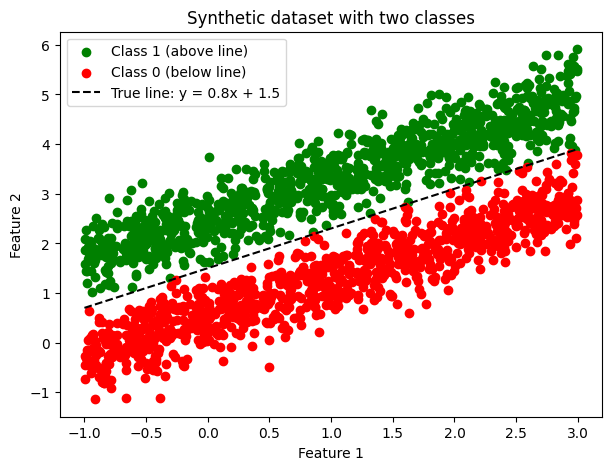

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters of the "true" separating line
slope = 0.8
intercept = 1.5

# Generate x-values
rng = np.random.default_rng(42)
n_points = 2000
x_values = rng.uniform(-1, 3, n_points)

# Generate line values
y_line = slope * x_values + intercept

# Positive class: add positive noise
feature_1_pos = x_values
feature_2_pos = y_line + abs(rng.normal(loc=1.0, scale=0.4, size=n_points))
X_pos = np.column_stack([feature_1_pos, feature_2_pos])

# Negative class: add negative noise
feature_1_neg = x_values
feature_2_neg = y_line - abs(rng.normal(loc=1.0, scale=0.4, size=n_points))
X_neg = np.column_stack([feature_1_neg, feature_2_neg])

# Labels
y_pos_labels = np.ones(n_points, dtype=int)
y_neg_labels = np.zeros(n_points, dtype=int)

# Combine
X = np.vstack([X_pos, X_neg])
print(X.shape)
y = np.hstack([y_pos_labels, y_neg_labels])
print(y.shape)

# Plot
n_points_to_plot = 1000
plt.figure(figsize=(7, 5))
plt.scatter(feature_1_pos[:n_points_to_plot], feature_2_pos[:n_points_to_plot], c="green", label="Class 1 (above line)")
plt.scatter(feature_1_neg[:n_points_to_plot], feature_2_neg[:n_points_to_plot], c="red", label="Class 0 (below line)")


# Plot the true separating line
feature_1_min, feature_1_max = X[:,0].min(), X[:,0].max()

# Compute corresponding feature_2 values using the line equation
feature_2_for_feature_1_min = slope * feature_1_min + intercept
feature_2_for_feature_1_max = slope * feature_1_max + intercept

# Draw the line between these two points
plt.plot([feature_1_min, feature_1_max], [feature_2_for_feature_1_min, feature_2_for_feature_1_max], "k--", label=f"True line: y = {slope}x + {intercept}")


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic dataset with two classes")
plt.legend()
plt.show()


---

Now that we have our dataset and the “ideal” separating line, the next question is:  

Given a new point (Feature 1, Feature 2), how do we decide if it belongs to the **green class** (above the line) or the **red class** (below the line)?  

One way to think about it is:  
- Take the x-coordinate of the point,  
- Use the line equation `y = 0.8x + 1.5` to compute what the line’s y-value would be there,  
- Compare the point’s actual y-value to the line’s y-value:  
  - If the point’s y is greater, it’s above the line (green class).  
  - If the point’s y is smaller, it’s below the line (red class).  

That’s the **geometric intuition**.  

Next, logistic regression will take this idea and turn it into a **probability-based prediction rule** that works not just in 2D, but in higher dimensions too.


---

So far, our rule has been geometric:  
- If a point is above the line => green class.  
- If it’s below => red class.  

But in real data, things aren’t always so clean. Points can overlap, and we’d like our model to express **how confident** it is.  

This is where **logistic regression** introduces the **logit (sigmoid) function**:  

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

The sigmoid squashes any number into the range \([0,1]\), which we can interpret as a **probability**:  

- $ \sigma(z) \approx 1 $ => very likely green class.  
- $ \sigma(z) \approx 0 $ => very likely red class.  
- $ \sigma(z) \approx 0.5 $ => right on the boundary between the two.  

So the natural decision rule is:  
- predict **green** if $\sigma(z) \geq 0.5$  
- predict **red** if $\sigma(z) < 0.5$  

---

### Where does \(z\) come from?

In logistic regression, \(z\) is computed as a **linear combination of the features**:  

$$
z = w_1 \cdot \text{Feature}_1 + w_2 \cdot \text{Feature}_2 + b
$$

Here $w_1$, $w_2$, and $b$ are the **parameters learned by the model**, not the slope and intercept we used earlier to *generate* the dataset.  

Now, notice:  
- The decision boundary happens when $\sigma(z) = 0.5$.  
- Since $\sigma(0) = 0.5$, this is equivalent to **all points where $z = 0$**.  

So the decision boundary is given by:  

$$
w_1 \cdot \text{Feature}_1 + w_2 \cdot \text{Feature}_2 + b = 0
$$

Rearranging into slope–intercept form:  

$$
\text{Feature}_2 = -\frac{w_1}{w_2} \cdot \text{Feature}_1 - \frac{b}{w_2}
$$

This looks like a line again - but it’s derived from the model’s learned parameters.


In [56]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Test it on a few values
test_values = np.array([-5, -1, 0, 1, 5])
print("z:", test_values)
print("sigmoid(z):", sigmoid(test_values))


z: [-5 -1  0  1  5]
sigmoid(z): [0.00669285 0.26894142 0.5        0.73105858 0.99330715]


#### Let's also shuffle our data since we currently have the positive class datapoints as first half of the dataset and the negative as second...

In [57]:
# Shuffle to remove ordering bias
rng = np.random.default_rng(42)  # reproducible shuffle
indices = rng.permutation(len(X))

X = X[indices]
y = y[indices]

#### Let's do the same augmentation trick as we did during linear regression


In [58]:
import numpy as np
X_aug = np.hstack([X, np.ones((X.shape[0], 1))])
print('Shape of augmented X:', X_aug.shape)
print(X_aug[:5, :])

Shape of augmented X: (4000, 3)
[[0.66666399 3.26985949 1.        ]
 [2.14756553 3.62712932 1.        ]
 [0.37856355 2.94365202 1.        ]
 [0.8356631  1.06594692 1.        ]
 [0.75354503 1.38069977 1.        ]]


### Let's add a function to calculate z
#### And plug z into the sigmoid


In [59]:
def calculate_z(X, W):
    """
    Computes z = w1*x1 + w2*x2 + b
    Features should already be augmented with a bias term.
    """
    return np.dot(X, W)

rng = np.random.default_rng(0)
W_random_test = rng.normal(scale=0.9, size=(X_aug.shape[1], 1))
z = calculate_z(X_aug, W_random_test)
y_hat = sigmoid(z)  # shape (n_records, 1)

print("=== Random Test Setup ===")
print(f"Random weights (w1, w2, b): {W_random_test.T}")
print(f"X_aug shape: {X_aug.shape}   (n_records, 3)")
print(f"Random weights shape: {W_random_test.shape}   (3,1)")
print(f"y_hat shape: {y_hat.shape}   (n_records, 1)")

print("\n=== Sample Predictions ===")
print("First 5 z values:", np.round(z[:5].ravel(), 4))
print("First 5 predicted probabilities:", np.round(y_hat[:5].ravel(), 4))
print("First 5 true labels:", y[:5])


=== Random Test Setup ===
Random weights (w1, w2, b): [[ 0.1131572  -0.11889438  0.57638039]]
X_aug shape: (4000, 3)   (n_records, 3)
Random weights shape: (3, 1)   (3,1)
y_hat shape: (4000, 1)   (n_records, 1)

=== Sample Predictions ===
First 5 z values: [0.2631 0.3881 0.2692 0.5442 0.4975]
First 5 predicted probabilities: [0.5654 0.5958 0.5669 0.6328 0.6219]
First 5 true labels: [1 1 1 0 0]


### Loss Function

So far, we can calculate predictions $\hat{y}$ as probabilities between 0 and 1.  

Now we need a way to **measure how well our model is doing** compared to the true labels.  

For classification, the most common loss function is **Binary Cross-Entropy (BCE)**, also known as **Log Loss**:

$$
\text{Loss} = - \frac{1}{N} \sum_{i=1}^N \Big[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \Big]
$$

- $y^{(i)}$ = true label (0 or 1)  
- $\hat{y}^{(i)}$ = predicted probability for class 1  

Intuition:  
- If the true label is 1, the loss is small only if $\hat{y}$ is close to 1.  
- If the true label is 0, the loss is small only if $\hat{y}$ is close to 0.  
- Wrong or overconfident predictions get **heavily penalized**.  

This makes BCE a natural choice for logistic regression: it encourages the model to output probabilities that match the data as closely as possible.


In [60]:
def binary_cross_entropy(y_true, y_pred):
    """
    Computes Binary Cross-Entropy (Log Loss).
    
    NOTE: If a prediction is exactly 0 or 1, log(0) = -inf.
    To keep things simple for teaching, we compute the loss
    normally and then cap it so it never goes infinite.
    """
    # Compute the raw loss
    term1 = y_true * np.log(y_pred.ravel())
    term2 = (1 - y_true) * np.log(1 - y_pred.ravel())
    loss = -np.mean(term1 + term2)
    
    # Cap the loss so it's never infinite
    max_loss = 1e6
    if np.isinf(loss) or np.isnan(loss):
        loss = max_loss
    
    return loss


# Compute loss for our current predictions
loss_value = binary_cross_entropy(y, y_hat)

print("=== Loss Check ===")
print(f"Mean Binary Cross-Entropy loss for the dataset (random weights): {loss_value:.4f}")


=== Loss Check ===
Mean Binary Cross-Entropy loss for the dataset (random weights): 0.7766


### Loss Gradient

---

Now that we have a way to measure **how wrong** our predictions are (the BCE loss), the next step is to figure out **how to adjust the weights** so the loss goes down.  

This is where we need the **gradient** of the loss with respect to the weights.  

The full derivation of the gradient for logistic regression involves a bit of calculus (chain rule + the derivative of the sigmoid). To keep things simple, we’ll skip the detailed math here.  

But after working it out, the result is surprisingly clean:

$$
\nabla_W \, \text{Loss} = \frac{1}{N} X^T (\hat{y} - y)
$$

- $X$ = the feature matrix (augmented with bias)  
- $\hat{y}$ = predicted probabilities (from sigmoid)  
- $y$ = true labels  
- $N$ = number of training samples  

This gradient tells us the direction to nudge each weight so that the predictions get closer to the true labels.


In [61]:
def compute_gradient(X, y_true, y_pred):
    """
    Computes gradient of BCE loss w.r.t weights.
    
    X: augmented feature matrix, shape (n_samples, n_features+1)
    y_true: true labels, shape (n_samples,)
    y_pred: predicted probabilities, shape (n_samples, 1)
    """
    n_samples = X.shape[0]
    # difference between predictions and true labels
    error = y_pred.ravel() - y_true
    # gradient formula
    # X.T.shape = (num_features, n_samples), so we have to reshape error(1, n_samples) to (n_samples, 1)
    grad = (1 / n_samples) * np.dot(X.T, error.reshape(n_samples, 1))
    return grad

# Example: compute gradient for our random weights
grad_example = compute_gradient(X_aug, y, y_hat)
print("Gradient shape:", grad_example.shape)
print("First few gradient values:\n", np.round(grad_example.ravel(), 4))


Gradient shape: (3, 1)
First few gradient values:
 [ 0.1092 -0.2967  0.1022]


### Predict function

In [78]:
def predict_classes(y_hat, threshold=0.5):
    """
    Convert probabilities to hard class predictions.
    Default threshold = 0.5
    """
    return (y_hat >= threshold).astype(int)


### Accuracy


In [80]:
def accuracy(y_true, y_pred_classes):
    """
    Compute accuracy: fraction of correct predictions.
    """
    return np.mean(y_true == y_pred_classes.ravel())

### Training Loop
We just copy the one from Linear Regression and change up how we calculate the prediction, the loss and the gradient


In [85]:
# Start with random weights W (including the bias term). 
rng = np.random.default_rng(0)
W = rng.normal(scale=0.1, size=(X_aug.shape[1], 1))  # (3,1): w1, w2, bias
print("W.shape():", W.shape)
print("Random weights (w1, w2, b):", W.T)

# Hyperparameters
learning_rate = 0.02
num_epochs = 10000
gradient_magnitude_convergence_threshold = 1e-3

for epoch in range(num_epochs):
    # Forward pass
    z = calculate_z(X_aug, W)
    y_hat = sigmoid(z)  # shape (n_records, 1)
    assert y_hat.shape[0] == X_aug.shape[0]
    
    # Loss
    loss = binary_cross_entropy(y, y_hat)
    
    # Gradient
    mean_gradient = compute_gradient(X_aug, y, y_hat)
    
    # Update weights
    W = W - learning_rate * mean_gradient
    
    # Gradient norm for convergence check
    gradient_magnitude = np.linalg.norm(mean_gradient)
    
    # Accuracy
    y_pred_classes = predict_classes(y_hat)
    acc = accuracy(y, y_pred_classes)
    
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:4d} | loss={loss:.6f} | "
              f"grad_norm={gradient_magnitude:.6e} | "
              f"accuracy={acc:.4f} | W.T={W.T}")
    
    if gradient_magnitude <= gradient_magnitude_convergence_threshold:
        print(f"Converged at epoch {epoch+1}: loss={loss:.6f}, "
              f"grad_norm={gradient_magnitude:.3e}, "
              f"accuracy={acc:.4f}, W.T={W.T}")
        break


W.shape(): (3, 1)
Random weights (w1, w2, b): [[ 0.01257302 -0.01321049  0.06404227]]
Epoch    1 | loss=0.700099 | grad_norm=4.809386e-01 | accuracy=0.5000 | W.T=[[ 0.01232547 -0.00359768  0.06381111]]
Epoch  100 | loss=0.554902 | grad_norm=2.152008e-01 | accuracy=0.6145 | W.T=[[-0.23766024  0.37709623 -0.13124944]]
Epoch  200 | loss=0.476302 | grad_norm=1.824735e-01 | accuracy=0.8230 | W.T=[[-0.48307402  0.58457969 -0.36164393]]
Epoch  300 | loss=0.418421 | grad_norm=1.585327e-01 | accuracy=0.8988 | W.T=[[-0.67611431  0.76093575 -0.57824814]]
Epoch  400 | loss=0.373908 | grad_norm=1.403380e-01 | accuracy=0.9327 | W.T=[[-0.83238143  0.91434644 -0.78018893]]
Epoch  500 | loss=0.338526 | grad_norm=1.260049e-01 | accuracy=0.9485 | W.T=[[-0.96253209  1.04976887 -0.96805144]]
Epoch  600 | loss=0.309689 | grad_norm=1.143791e-01 | accuracy=0.9600 | W.T=[[-1.07357495  1.17085307 -1.14283537]]
Epoch  700 | loss=0.285720 | grad_norm=1.047329e-01 | accuracy=0.9685 | W.T=[[-1.17023608  1.28030874 

### Learned Decision Boundary
Let's see if we can plot the learned decision boundary.
We haven't learned the boundary directly, but we have learned the logistic regression weights for the following equation:

$$
w_1 \cdot x + w_2 \cdot y + b = 0
$$


Solve for $y$:

$$
y = -\frac{w_1}{w_2} \cdot x - \frac{b}{w_2}
$$

So:

- **Slope** = $-\tfrac{w_1}{w_2}$
- **Intercept** = $-\tfrac{b}{w_2}$


In [89]:
w1, w2, b = W.ravel()
# Compute slope and intercept of decision boundary
baseline_slope = 0.8
baseline_intercept = 1.5
slope = -w1 / w2
intercept = -b / w2
print("Learned Slope:", slope)
print("Learned Intercept:", intercept)


Slope: 0.8235380030302226
Intercept: 1.4133698423688583


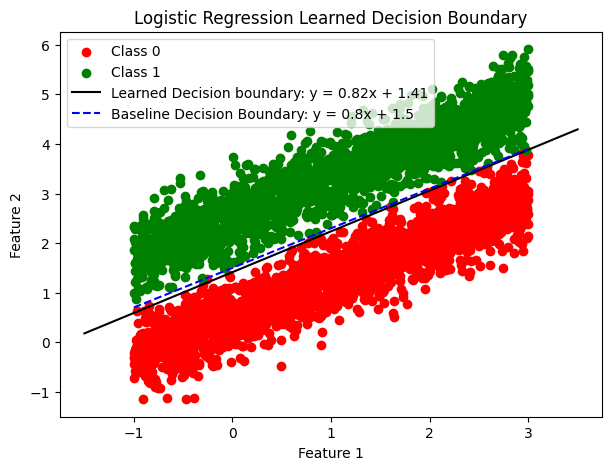

In [90]:
# Generate x values across feature_1 range
x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
xx = np.linspace(x_min, x_max, 100)
yy = slope * xx + intercept

# Plot dataset
plt.figure(figsize=(7,5))
plt.scatter(X[y==0, 0], X[y==0, 1], c="red", label="Class 0")
plt.scatter(X[y==1, 0], X[y==1, 1], c="green", label="Class 1")

# Plot learned decision boundary
plt.plot(xx, yy, "k-", label=f"Learned Decision boundary: y = {slope:.2f}x + {intercept:.2f}")
plt.plot([feature_1_min, feature_1_max], [feature_2_for_feature_1_min, feature_2_for_feature_1_max], "b--", label=f"Baseline Decision Boundary: y = {baseline_slope}x + {baseline_intercept}")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Learned Decision Boundary")
plt.legend()
plt.show()